**Description:** This notebook demonstrates the application of PIP-MYULA to the Bayesian neural network considered in Section 3.2 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/) but changing the normal prior on the weights with Laplace priors that induce sparsity.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [2]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 1 and 7:
indices = (labels == 1) | (labels == 7)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 1 as 0 and 7 as 1:
for n in range(labels.size):
    if labels[n] == 1:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries (pixels across whole dataset) so that they have mean zero 
# and unit standard across the dataset:
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

2025-02-10 14:32:10.041911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739197930.059113 2097366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739197930.064406 2097366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.
*   gamma: Smoothing parameter of the Moreau-Yosida envelope.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [3]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))  
sys.path.append(project_root)

from bayesian_neural_network.activation_function.algorithms_nondiff_activation import my_ipla_bnn_activation, my_ipla_bnn_performance_activation, my_pgd_bnn_activation, my_pgd_bnn_performance_activation, pipgla_bnn_activation, pipgla_bnn_performance_activation

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

### Predictive performance

In [4]:
from bayesian_neural_network.activation_function.algorithms_nondiff_activation import log_pointwise_predictive_density, test_error

In [5]:
# Split data into 80/20 training and testing sets:
# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 250  # Number of steps.
N = 50  # Number of particles.
gamma = 0.5 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([0])  # Alpha.
b0 = np.array([0])  # Beta.

In [6]:
M = 10 # Number of runs.
N = 50 # Number of particles.

# Initialize arrays storing the LPPDs and test errors:
lppd_pgd_values = []
error_pgd_values = []

lppd_myipla_values = []
error_myipla_values = []

lppd_pipgla_values = []
error_pipgla_values = []

for m in range(M):
    print('Run ' + str(m) + ' out of ' + str(M) + '.')
    
    # Randomize the initialization of the particle cloud:
    w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # w-components.
    v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # v-components.
    
    # Randomize the 80/20 testing/training split of the data:
    itrain, itest, ltrain, ltest = train_test_split(images, labels, 
                                                    test_size=0.2,
                                                    random_state=m)
    # Run the algorithms:
    _, _, _, _, lppd_pgd, error_pgd = my_pgd_bnn_activation(ltrain, itrain, ltest, itest,h, K, a0, b0, w0, v0, gamma)

    _, _, _, _, lppd_myipla, error_myipla = my_ipla_bnn_activation(ltrain, itrain, ltest, itest,h, K, a0, b0, w0, v0, gamma)

    _, _, _, _, lppd_pipgla, error_pipgla = pipgla_bnn_activation(ltrain, itrain, ltest, itest,h, K, a0, b0, w0, v0, gamma)
    
    # Compute LPPDs:
    lppd_pgd_values.append(lppd_pgd)

    error_pgd_values.append(error_pgd)

    lppd_myipla_values.append(lppd_myipla)

    error_myipla_values.append(error_myipla) 

    lppd_pipgla_values.append(lppd_pipgla) 

    error_pipgla_values.append(error_pipgla) 

Run 0 out of 10.


100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


Run 1 out of 10.


100%|██████████| 250/250 [00:32<00:00,  7.67it/s]


Run 2 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.28it/s]


Run 3 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.25it/s]


Run 4 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.17it/s]


Run 5 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.24it/s]


Run 6 out of 10.


100%|██████████| 250/250 [00:35<00:00,  7.09it/s]


Run 7 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.23it/s]


Run 8 out of 10.


100%|██████████| 250/250 [00:33<00:00,  7.45it/s]


Run 9 out of 10.


100%|██████████| 250/250 [00:34<00:00,  7.25it/s]


#### Plot

In [22]:
matrix_error_mypgd = np.array(error_pgd_values)
means_mypgd = np.mean(matrix_error_mypgd, axis=0)
std_devs_mypgd = np.std(matrix_error_mypgd, axis=0)


matrix_error_myipla = np.array(error_myipla_values)
means_myipla = np.mean(matrix_error_myipla, axis=0)
std_devs_myipla = np.std(matrix_error_myipla, axis=0)

matrix_error_pipgla = np.array(error_pipgla_values)
means_pipgla = np.mean(matrix_error_pipgla, axis=0)
std_devs_pipgla = np.std(matrix_error_pipgla, axis=0)

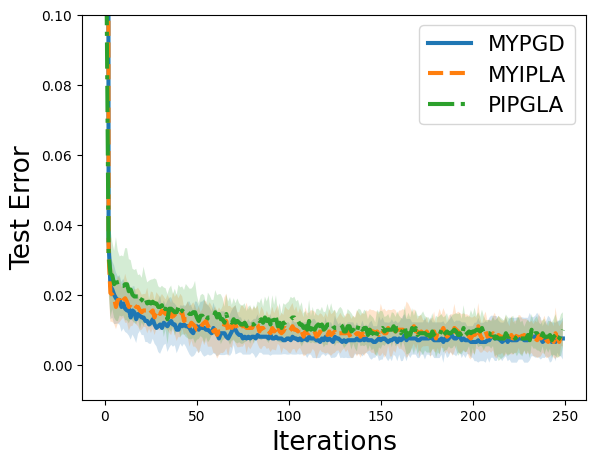

In [23]:
import matplotlib.pyplot as plt

fig_size = (6.5, 5)
# Plot the data
fig = plt.figure(figsize=fig_size)

## MYPGD
plt.plot(means_mypgd, label = 'MYPGD', linewidth=2.95, linestyle = "solid")
plt.fill_between(np.linspace(0, 249, 250), np.array(means_mypgd) - np.array(std_devs_mypgd), 
                 np.array(means_mypgd) + np.array(std_devs_mypgd), 
                 alpha=0.2)

## MYIPLA
plt.plot(means_myipla, label = 'MYIPLA', linewidth=2.95, linestyle='dashed')
plt.fill_between(np.linspace(0, 249, 250), np.array(means_myipla) - np.array(std_devs_myipla), 
                 np.array(means_myipla) + np.array(std_devs_myipla), 
                 alpha=0.2)

## PIPGLA 
plt.plot(means_pipgla, label = 'PIPGLA', linewidth=2.95, linestyle = "dashdot")
plt.fill_between(np.linspace(0, 249, 250), np.array(means_pipgla) - np.array(std_devs_pipgla), 
                 np.array(means_pipgla) + np.array(std_devs_pipgla), 
                 alpha=0.2)


# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('Test Error', fontsize=19)
plt.ylim(-0.01, 0.1)

plt.legend(fontsize=15.5, loc='upper right')


path_evolution_error_fig = os.path.join(project_root, 'bayesian_neural_network/activation_function/evolution_test_error_N_50.pdf')
fig.savefig(path_evolution_error_fig, format='pdf', bbox_inches='tight')


In [24]:
matrix_lppd_mypgd = np.array(lppd_pgd_values)
means_mypgd_lppd = np.mean(matrix_lppd_mypgd, axis=0)
std_devs_mypgd_lppd = np.std(matrix_lppd_mypgd, axis=0)


matrix_lppd_myipla = np.array(lppd_myipla_values)
means_myipla_lppd = np.mean(matrix_lppd_myipla, axis=0)
std_devs_myipla_lppd = np.std(matrix_lppd_myipla, axis=0)

matrix_lppd_pipgla = np.array(lppd_pipgla_values)
means_pipgla_lppd = np.mean(matrix_lppd_pipgla, axis=0)
std_devs_pipgla_lppd = np.std(matrix_lppd_pipgla, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


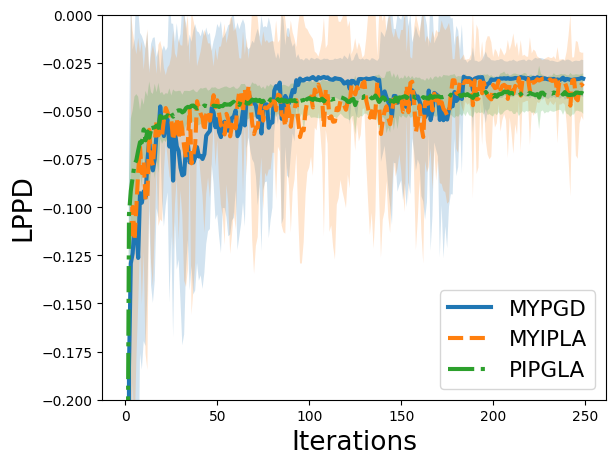

In [25]:
import matplotlib.pyplot as plt

fig_size = (6.5, 5)
# Plot the data
fig = plt.figure(figsize=fig_size)

## MYPGD
plt.plot(means_mypgd_lppd, label = 'MYPGD', linewidth=2.95, linestyle = "solid")
plt.fill_between(np.linspace(0, 249, 250), np.array(means_mypgd_lppd) - np.array(std_devs_mypgd_lppd), 
                 np.array(means_mypgd_lppd) + np.array(std_devs_mypgd_lppd), 
                 alpha=0.2)

## MYIPLA
plt.plot(means_myipla_lppd, label = 'MYIPLA', linewidth=2.95, linestyle='dashed')
plt.fill_between(np.linspace(0, 249, 250), np.array(means_myipla_lppd) - np.array(std_devs_myipla_lppd), 
                 np.array(means_myipla_lppd) + np.array(std_devs_myipla_lppd), 
                 alpha=0.2)

## PIPGLA 
plt.plot(means_pipgla_lppd, label = 'PIPGLA', linewidth=2.95, linestyle = "dashdot")
plt.fill_between(np.linspace(0, 249, 250), np.array(means_pipgla_lppd) - np.array(std_devs_pipgla_lppd), 
                 np.array(means_pipgla_lppd) + np.array(std_devs_pipgla_lppd), 
                 alpha=0.2)


# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('LPPD', fontsize=19)
plt.ylim(-0.2, 0)
#plt.xlim(5, 250)

plt.legend(fontsize=15.5, loc='lower right')


path_evolution_lppd_fig = os.path.join(project_root, 'bayesian_neural_network/activation_function/evolution_lppd_N_50.pdf')
fig.savefig(path_evolution_lppd_fig, format='pdf', bbox_inches='tight')